In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os

In [2]:
print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 2.10.0


In [3]:
train_image_path = glob.glob("./dataset/dc/train/*/*.jpg")

In [4]:
len(train_image_path)

2000

In [5]:
train_image_path[-5]

'./dataset/dc/train\\dog\\dog.995.jpg'

In [6]:
p = './dataset/dc/train\\cat\\cat.0.jpg'
p = p.split("\\")
int(p[1]=='cat')

1

In [7]:
# 如果是猫的话，就是1，是狗就是0
train_image_label = [int(path.split("\\")[1]=="cat") for path in train_image_path]

In [8]:
train_image_label[:5]

[1, 1, 1, 1, 1]

In [9]:
train_image_label[-5:]

[0, 0, 0, 0, 0]

In [10]:
# 读取图片并解码函数
def load_preprosess_image(path, label):
    # 读取图片
    image = tf.io.read_file(path)
    # 解码文件
    image = tf.image.decode_jpeg(image, channels=3)
    # 扭曲图像，使其固定图像大小
    image = tf.image.resize(image,[360,360])
    # 图像增强
    # 随机裁剪
    image = tf.image.random_crop(image, [256,256,3])
    # 左右翻转
    image = tf.image.random_flip_left_right(image)
    # 上下翻转
    image = tf.image.random_flip_up_down(image)
    # 改变亮度
    image = tf.image.random_brightness(image, 0.5)
    # 改变对比度
    image = tf.image.random_contrast(image, 0, 1)
    # 改变图像的数据类型
    image = tf.cast(image, tf.float32)
    # 归一化
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [11]:
train_image_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label))

In [12]:
# 根据计算机的cpu个数，进行计算
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
train_image_dataset = train_image_dataset.map(load_preprosess_image, num_parallel_calls=AUTOTUNE)

In [14]:
train_image_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1,), dtype=tf.int32, name=None))>

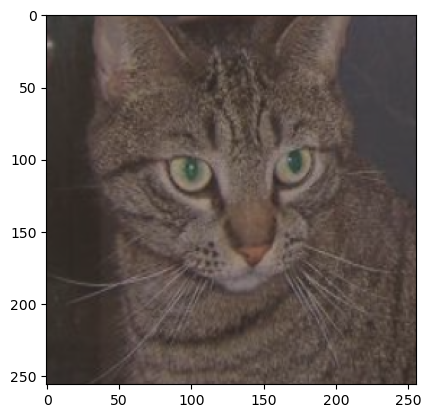

In [16]:
for img, label in train_image_dataset.take(2):
    plt.imshow(img)

In [17]:
BATCH_SIZE = 32
train_count = len(train_image_path)

In [18]:
train_image_dataset = train_image_dataset.shuffle(train_count).batch(BATCH_SIZE)
# 加速提取，前面在运行的时候，后台去取图片
train_image_dataset = train_image_dataset.prefetch(AUTOTUNE)

In [ ]:
# 读取图片并解码函数
def load_preprosess_image_test(path, label):
    # 读取图片
    image = tf.io.read_file(path)
    # 解码文件
    image = tf.image.decode_jpeg(image, channels=3)
    # 扭曲图像，使其固定图像大小
    image = tf.image.resize(image,[360,360])
    # 改变图像的数据类型
    image = tf.cast(image, tf.float32)
    # 归一化
    image = image / 255
    label = tf.reshape(label, [1])
    return image, label

In [19]:
test_image_path = glob.glob("./dataset/dc/test/*/*.jpg")

In [20]:
test_image_label = [int(path.split("\\")[1]=="cat") for path in test_image_path]

In [21]:
test_image_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))

In [22]:
test_image_dataset = test_image_dataset.map(load_preprosess_image_test, num_parallel_calls=AUTOTUNE)

In [23]:
test_image_dataset = test_image_dataset.batch(BATCH_SIZE)
# 加速提取，前面在运行的时候，后台去取图片
test_image_dataset = test_image_dataset.prefetch(AUTOTUNE)

In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(64, [3, 3], input_shape=(256,256,3), activation="relu"),
    keras.layers.Conv2D(64, [3, 3], activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, [3, 3], activation="relu"),
    keras.layers.Conv2D(128, [3, 3], activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, [3, 3], activation="relu"),
    keras.layers.Conv2D(256, [3, 3], activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(512, [3, 3], activation="relu"),
    keras.layers.Conv2D(512, [3, 3], activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1024, [3, 3], activation="relu"),
    keras.layers.Conv2D(1024, [3, 3], activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
model.summary()

In [ ]:
# 定义损失函数方法，可调用型的
loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# 定义优化器
optimizer = tf.keras.optimizers.Adam()

In [ ]:
epoch_loss_avg = tf.keras.metrics.Mean("train_loss")
train_accuracy = tf.keras.metrics.Accuracy()
epoch_loss_avg_test = tf.keras.metrics.Mean("test_loss")
test_accuracy = tf.keras.metrics.Accuracy()

In [ ]:
def train_step(model, images, labels):
    with tf.GradientTape() as t:
        pred = model(images)
        loss_step = loss_func(labels, pred)
    grads = t.gradient(loss_step, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels, tf.cast(pred>0,tf.int32))

In [ ]:
def test_step(model, images, label):
    pred = model(images,training=False)
    loss_step = loss_func(labels, pred)
    epoch_loss_avg(loss_step)
    train_accuracy(labels, tf.cast(pred>0,tf.int32))

In [ ]:
train_loss_result = []
train_accuracy_result = []
test_loss_result = []
test_accuracy_result = []

In [ ]:
num_epochs = 10

In [ ]:
for epoch in range(num_epochs):
    for images_, labels_ in train_image_dataset:
        train_step(model, images_, labels_)
        print(".", end="")
    print()
    train_loss_result.append(epoch_loss_avg.result())
    train_accuracy_result.append(train_accuracy.result())
    print("Epoch: {}, loss: {:.3f}, accuracy: {:.3f}".format(epoch,epoch_loss_avg.result(),train_accuracy.result()))
    for image_test, label_test in test_image_dataset:
        test_step(model, image_test, label_test)
        print(".", end="")
    test_loss_result.append(epoch_loss_avg_test.result())
    test_accuracy_result.append(test_accuracy.result())
    print("test_Epoch: {}, test_loss: {}, test_accuracy: {}".format(epoch,epoch_loss_avg_test.result(),test_accuracy.result()))
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()